In [70]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
from matplotlib_venn import venn2, venn3, venn3_circles
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from statsmodels.stats.multitest import fdrcorrection
import dateutil
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline


In [3]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]
bg_dict = {'diabetic': diabetic, 'impaired': impaired, 'normal': normal}
animal_to_tolerance_dict = {1076: 'diabetic', 1082: 'diabetic',1101: 'diabetic',
                            1060: 'impaired', 1062: 'impaired', 1074: 'impaired',
                            1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal',}

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
df = pd.read_csv(r'..\data\processed\combined_metab_lipid_table.csv', index_col=0)
data_cols = df.filter(regex='FBG|RBG').columns
pval_cols = df.filter(regex='pval').columns

In [5]:
fg

,File Name_lipid,lipid_run_order,fr_name,animal,bg_type,quant_file,week,lipidex_file_number,date,glucose_tolerance,bg,File Name_metab,metab_run_order,fixed_filename,qc_file,blank_file,gluc_tol,combined_col_name
0,20210729_AJ_Toh_RatBloodGlucose_T1076M_2021040...,7,20210729_AJ_Toh_RatBloodGlucose_T1076M_2021040...,1076,FBG,True,10,27,2021-04-05,diabetic,71.000000,20210831_KAO_HILIC_T1076M_20210405_10wk_FBG,21,20210831_KAO_HILIC_T1076M_20210405_10wk_FBG,False,False,diabetic,1076_10_FBG
1,20210729_AJ_Toh_RatBloodGlucose_T1062M_2021032...,8,20210729_AJ_Toh_RatBloodGlucose_T1062M_2021032...,1062,FBG,True,8,9,2021-03-22,impaired,52.333333,20210831_KAO_HILIC_T1062M_20210322_8wk_FBG,61,20210831_KAO_HILIC_T1062M_20210322_8wk_FBG,False,False,impaired,1062_8_FBG
2,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021040...,9,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021040...,1093,FBG,True,9,49,2021-04-02,normal,64.000000,20210831_KAO_HILIC_T1093M_20210402_9wk_FBG,50,20210831_KAO_HILIC_T1093M_20210402_9wk_FBG,False,False,normal,1093_9_FBG
3,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021032...,10,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021032...,1060,RBG,True,8,4,2021-03-25,impaired,225.000000,20210831_KAO_HILIC_T1060M_20210325_8wk_RBG,59,20210831_KAO_HILIC_T1060M_20210325_8wk_RBG,False,False,impaired,1060_8_RBG
4,20210729_AJ_Toh_RatBloodGlucose_T1091M_2021041...,11,20210729_AJ_Toh_RatBloodGlucose_T1091M_2021041...,1091,FBG,True,10,39,2021-04-10,normal,48.500000,20210831_KAO_HILIC_T1091M_20210410_10wk_FBG,56,20210831_KAO_HILIC_T1091M_20210410_10wk_FBG,False,False,normal,1091_10_FBG
5,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021040...,12,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021040...,1092,RBG,True,9,44,2021-04-06,impaired,70.500000,20210831_KAO_HILIC_T1092M_20210406_9wk_RBG,18,20210831_KAO_HILIC_T1092M_20210406_9wk_RBG,False,False,impaired,1092_9_RBG
6,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021041...,13,20210729_AJ_Toh_RatBloodGlucose_T1093M_2021041...,1093,RBG,True,10,52,2021-04-13,normal,69.500000,20210831_KAO_HILIC_T1093M_20210413_10wk_RBG,45,20210831_KAO_HILIC_T1093M_20210413_10wk_RBG,False,False,normal,1093_10_RBG
7,20210729_AJ_Toh_RatBloodGlucose_T1082M_2021040...,14,20210729_AJ_Toh_RatBloodGlucose_T1082M_2021040...,1082,FBG,True,10,33,2021-04-05,diabetic,50.000000,20210831_KAO_HILIC_T1082M_20210405_10wk_FBG,41,20210831_KAO_HILIC_T1082M_20210405_10wk_FBG,False,False,diabetic,1082_10_FBG
8,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021040...,15,20210729_AJ_Toh_RatBloodGlucose_T1060M_2021040...,1060,RBG,True,9,6,2021-04-01,impaired,83.000000,20210831_KAO_HILIC_T1060M_20210401_9wk_RBG,5,20210831_KAO_HILIC_T1060M_20210401_9wk_RBG,False,False,impaired,1060_9_RBG
9,20210729_AJ_Toh_RatBloodGlucose_T1101M_2021040...,16,20210729_AJ_Toh_RatBloodGlucose_T1101M_2021040...,1101,FBG,True,9,55,2021-04-02,diabetic,43.000000,20210831_KAO_HILIC_T1101M_20210402_9wk_FBG,44,20210831_KAO_HILIC_T1101M_20210402_9wk_FBG,False,False,diabetic,1101_9_FBG


(array([  2.,   1.,  12.,  78., 384., 844., 350.,  49.,   5.,   4.]),
 array([-6.27454788, -5.10457057, -3.93459325, -2.76461594, -1.59463863,
        -0.42466132,  0.74531599,  1.91529331,  3.08527062,  4.25524793,
         5.42522524]),
 <BarContainer object of 10 artists>)

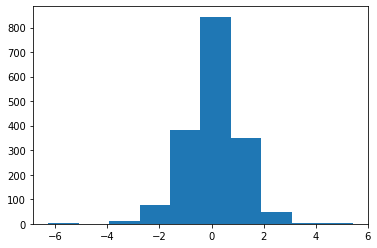

In [77]:
ss = StandardScaler()
plt.hist(ss.fit_transform(X_all)[3])

In [86]:
X_all = StandardScaler().fit_transform(df[data_cols].T)

X_only_conv = StandardScaler().fit_transform(df.loc[~df[pval_cols].isna().all(axis=1), data_cols].T)

gluc_tol_cols = ['fdr corrected pval effect of glucose tolerance', 
                 'fdr corrected pval effect of interaction sampling and glucose tolerance']
X_only_signf = StandardScaler().fit_transform(df.loc[(df[gluc_tol_cols] < 0.05).any(axis=1), data_cols].T)
# X_only_signf

In [83]:
# Generate data labels (y) for RF Classifier 

y = fg.set_index('combined_col_name')[['glucose_tolerance']]
y['glucose_tolerance'] = y['glucose_tolerance'].map({'normal': 0, 'impaired': 1, 'diabetic': 2})
y

y_continuous = fg.set_index('combined_col_name')['bg']

In [89]:
svc = SVC()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=100)
n_scores = cross_val_score(estimator=svc,
                           X=X_all,
                           y=y,
                           cv=cv,
                           scoring='accuracy', 
                           n_jobs=-1,
                           error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.557 (0.051)


In [90]:
svc = SVC()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=100)
n_scores = cross_val_score(estimator=svc,
                           X=X_only_conv,
                           y=y,
                           cv=cv,
                           scoring='accuracy', 
                           n_jobs=-1,
                           error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.558 (0.053)


In [93]:
svc = SVC()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=100)
n_scores = cross_val_score(estimator=svc,
                           X=X_only_signf,
                           y=y,
                           cv=cv,
                           scoring='accuracy', 
                           n_jobs=-1,
                           error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.642 (0.134)


## SVM Regressors

In [94]:
y_continuous

combined_col_name
1076_10_FBG     71.000000
1062_8_FBG      52.333333
1093_9_FBG      64.000000
1060_8_RBG     225.000000
1091_10_FBG     48.500000
1092_9_RBG      70.500000
1093_10_RBG     69.500000
1082_10_FBG     50.000000
1060_9_RBG      83.000000
1101_9_FBG      43.000000
1062_10_RBG    139.500000
1091_8_RBG     108.500000
1074_10_FBG     55.000000
1101_10_RBG    352.000000
1076_9_FBG      78.500000
1092_9_FBG      63.500000
1074_8_FBG     171.333333
1091_10_RBG     71.500000
1082_9_FBG      53.333333
1076_8_RBG     387.666667
1060_8_FBG      41.000000
1093_9_RBG      83.000000
1060_10_FBG     52.500000
1082_10_RBG    330.500000
1074_9_RBG     203.500000
1091_9_RBG      86.000000
1101_10_FBG     44.500000
1093_8_FBG      47.000000
1074_8_RBG     232.500000
1102_10_RBG    308.000000
1062_9_FBG      48.000000
1076_9_RBG     281.000000
1092_8_FBG      46.000000
1062_10_FBG     40.000000
1102_8_RBG     299.500000
1074_10_RBG    205.500000
1060_9_FBG      48.000000
1082_9_RBG     339.5

In [116]:
svr = SVR()
cv = RepeatedKFold(n_splits=58, n_repeats=70, random_state=100)
n_scores = cross_val_score(estimator=svr,
                           X=X_only_signf,
                           y=y_continuous,
                           cv=cv,
                           scoring='neg_mean_absolute_error', 
                           n_jobs=-1,
                           error_score='raise',
                           verbose=1000)
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), d

Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    5.8s
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.8s
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    5.8s
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling arra

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.0s
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:    6.0s
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:    6.0s
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (s

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:    6.2s
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).[Parallel(n_jobs=-1)]: Done 187 tasks      | elapsed:    6.6s

Pickling array (shape=(1,), dtype

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).[Parallel(n_jobs=-1)]: Done 259 tasks      | elapsed:    6.7s

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
[Pa

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling a

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).[Parallel(n_jobs=-1)]: Done 499 tasks      | elapsed:    7.3s

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pic

Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).[Parallel(n_jobs=-1)]: Done 563 tasks      | elapsed:    7.5s

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).[Parallel(n_jobs=-1)]: Done 771 tasks      | elapsed:    8.3

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 1027 tasks      | elapsed:    9.0s
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtyp

Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling a

Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 1251 tasks      | elapsed:    9.8s
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtyp

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling a

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=

Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).[Parallel(n_jobs=-1)]: Done 1779 tasks      | elapsed:   11.1s

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pi

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 1955 tasks      | elapsed:   11.5s
Pi

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).[Parallel(n_jobs=-1)]: Done 2019 tasks      | elapsed:   11.7s

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(59,), dtyp

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=

Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).[Parallel(n_jobs=-1)]: Done 2291 tasks      | elapsed:   12.5s

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtyp

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).[Parallel(n_jobs=-1)]: Done 2403 tasks      | elapsed:   12.9s

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtyp

Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling a

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(


Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling a

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).[Parallel(n_jobs=-1)]: Done 2931 tasks      | elapsed:   14.4s

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtyp

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).[Parallel(n_jobs=-1)]: Done 3107 tasks      | elapsed:   14.8s

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtyp

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 3267 tasks      | elapsed:   15.1s
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype

Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(58,), dtype=int32).
Pickling array (shape=(2,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).[Parallel(n_jobs=-1)]: Done 3459 tasks      | elapsed:   15.5s

Pickling array (shape=(59,), dtyp

Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 3571 tasks      | elapsed:   15.9s
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtyp

Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 3795 tasks      | elapsed:   16.3s
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtyp

Pickling array (shape=(1,), dtype=int32).
[Parallel(n_jobs=-1)]: Done 3875 out of 4060 | elapsed:   16.5s remaining:    0.7s
Pickling array (shape=(60, 449), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(60,), dtype=float64).
Pickling array (shape=(60,), dtype=object).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(59,), dtype=int32).
Pickling array (shape=(1,), dtype=int32).
Pickling arra

(array([6.600e+01, 0.000e+00, 0.000e+00, 6.400e+01, 1.000e+00, 1.380e+02,
        2.020e+02, 3.000e+00, 1.300e+02, 1.280e+02, 6.900e+01, 1.340e+02,
        1.360e+02, 2.150e+02, 1.420e+02, 1.700e+01, 7.300e+01, 3.000e+00,
        5.950e+02, 1.944e+03]),
 array([-385.9889598 , -366.7314201 , -347.4738804 , -328.2163407 ,
        -308.95880099, -289.70126129, -270.44372159, -251.18618189,
        -231.92864218, -212.67110248, -193.41356278, -174.15602308,
        -154.89848337, -135.64094367, -116.38340397,  -97.12586427,
         -77.86832456,  -58.61078486,  -39.35324516,  -20.09570546,
          -0.83816575]),
 <BarContainer object of 20 artists>)

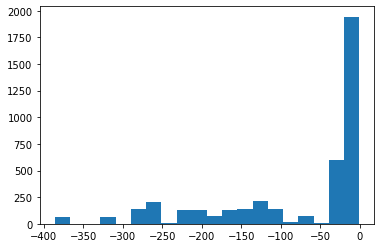

In [117]:
plt.hist(n_scores, bins=20)

In [64]:
# evaluate random forest ensemble for regression

# define the model
model = RandomForestRegressor()
# evaluate the model

## To do leave-one-out, set n_splits = n_observations in your training data 
cv = RepeatedKFold(n_splits=30, n_repeats=1, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

NameError: name 'RandomForestRegressor' is not defined

<module 'sklearn.metrics' from 'C:\\Users\\ben\\Anaconda3\\lib\\site-packages\\sklearn\\metrics\\__init__.py'>